<a href="https://colab.research.google.com/github/aryan-at-ul/graph_from_patches/blob/main/contextclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

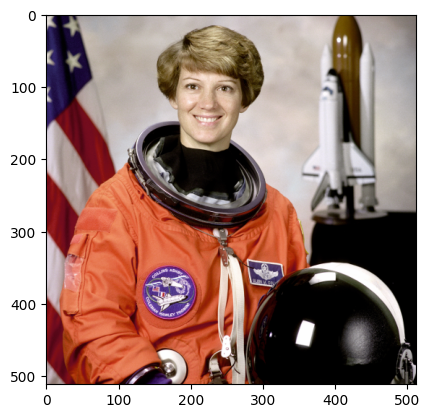

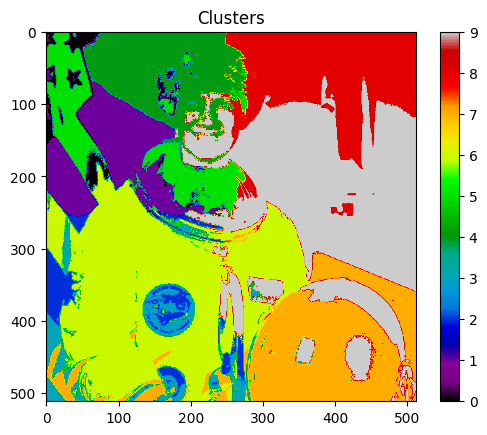

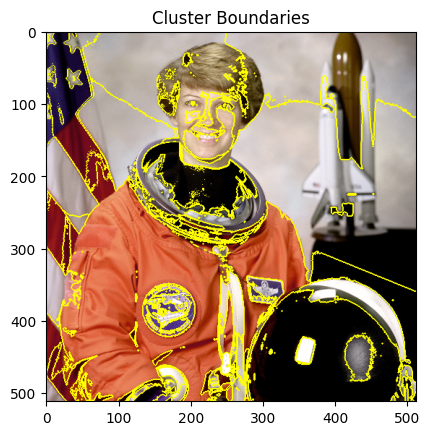

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, segmentation
from skimage.future import graph
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# def cluster_points(P, w, h, c, k):
#     Ps = P
#     x = np.linspace(-0.5, 0.5, int(np.sqrt(c)))
#     y = np.linspace(-0.5, 0.5, int(np.sqrt(c)))
#     grid_x, grid_y = np.meshgrid(x, y)
#     centers_xy = np.stack([grid_x.flatten(), grid_y.flatten()], axis=-1)
#     centers_rgb = np.zeros((c, 3))
#     nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, 3:])
#     _, indices = nbrs.kneighbors(centers_xy)
#     for i in range(c):
#         centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)
#     centers = np.hstack([centers_rgb, centers_xy])
#     S = cosine_similarity(Ps, centers)
#     cluster_assignments = np.argmax(S, axis=1)
#     return cluster_assignments

def cluster_points(P, w, h, c, k):
    # Adjust center creation to ensure c centers
    side_len = int(np.ceil(np.sqrt(c)))
    x = np.linspace(-0.5, 0.5, side_len)
    y = np.linspace(-0.5, 0.5, side_len)
    grid_x, grid_y = np.meshgrid(x, y)
    centers_xy = np.stack([grid_x.flatten(), grid_y.flatten()], axis=-1)[:c]  # Only take the first c centers
    centers_rgb = np.zeros((c, 3))

    # Get the k nearest points for each center and average to get the center features
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(P[:, 3:])
    _, indices = nbrs.kneighbors(centers_xy)
    for i in range(c):
        centers_rgb[i] = np.mean(P[indices[i], :3], axis=0)
    centers = np.hstack([centers_rgb, centers_xy])

    # Calculate cosine similarity
    S = cosine_similarity(P, centers)

    # Assign each point to the closest center
    cluster_assignments = np.argmax(S, axis=1)

    return cluster_assignments


# Load astronaut image
image = data.astronaut()
plt.imshow(image)
plt.show()
h, w, _ = image.shape

# Prepare the data
rgb = image.reshape(-1, 3) / 255.
xy = np.mgrid[0:h, 0:w].reshape(2, -1).T
xy = xy / np.array([h, w]) - 0.5
P = np.hstack([rgb, xy])

# Cluster points
c = 10
k = 4
assignments = cluster_points(P, w, h, c, k)

# Visualize the clusters
clustered_image = np.reshape(assignments, (h, w))
plt.imshow(clustered_image, cmap="nipy_spectral")
plt.colorbar()
plt.title('Clusters')
plt.show()

# Visualize the boundaries
edges = segmentation.mark_boundaries(image, clustered_image)
plt.imshow(edges)
plt.title('Cluster Boundaries')
plt.show()


this is the c 100
this is the c 100


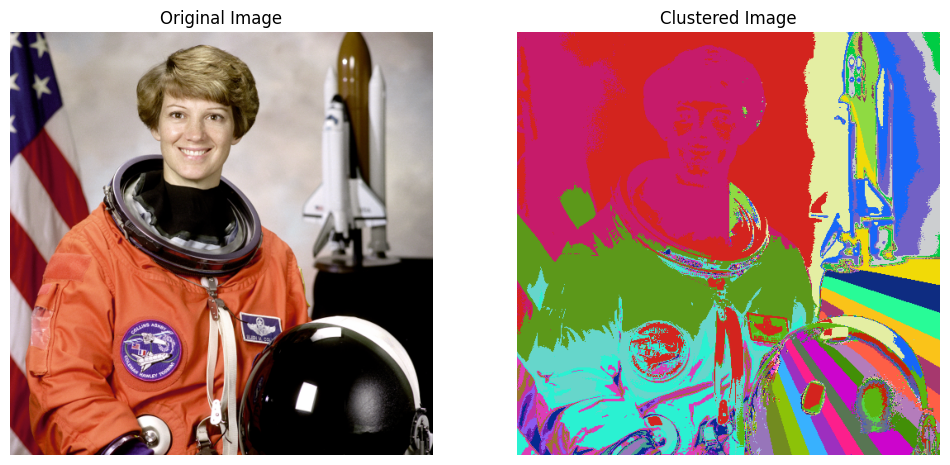

<ipython-input-57-715a232707a8>:120: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


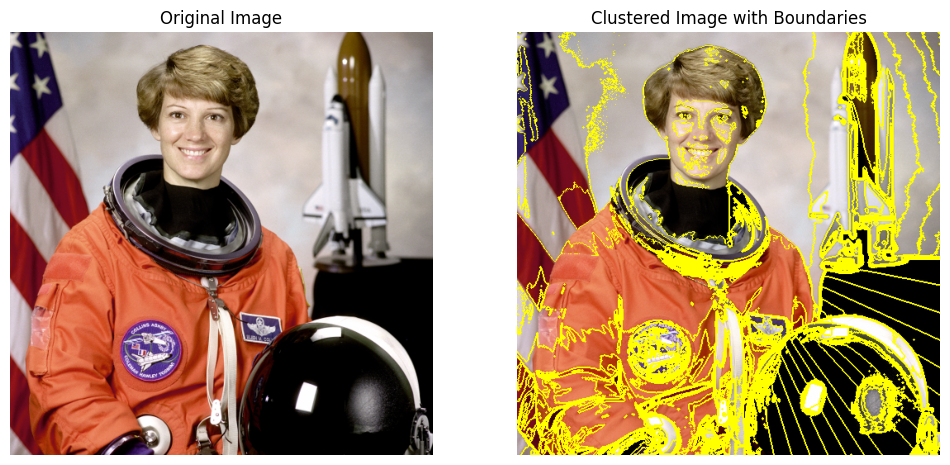

In [57]:



import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors




def context_clustering(P, c, k):
    h, w  =   P.shape
    # Linearly project P for similarity computation
    Ps = P

    # Proposed c centers in space evenly
    y_centers = np.linspace(0, h-1, int(np.sqrt(c)))
    x_centers = np.linspace(0, w-1, int(np.sqrt(c)))

    # side_len = int(np.ceil(np.sqrt(c)))
    # y_centers = np.linspace(0, h-1, side_len)
    # x_centers = np.linspace(0, w-1, side_len)


    centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)
    centers_rgb = np.zeros((c, 3))

    # Averaging k-nearest points for center features
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
    _, indices = nbrs.kneighbors(centers_xy)
    for i in range(c):
        if len(indices[i]) == 0:
            continue
        centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)

    centers = np.hstack([centers_rgb, centers_xy / [w, h]])
    S = cosine_similarity(Ps, centers)

    # Assigning each point to the most similar center
    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []

    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    print("this is the c",c)
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features = []

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        # Feature aggregating , P, centers, S, c, alpha, beta
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching #P, aggregated_features, cluster_assignments, c, alpha, beta
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        aggregated_features.append(P_new)

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 100
k = 5
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, int(c), k, alpha, beta, d0, h)

# Re-use the clustering function to get the cluster assignments
# cluster_assignments, _, _ = context_clustering(P, c, k)
# print(np.unique(cluster_assignments, return_counts=True))


# # Visualize
# clustered_image = visualize_clusters(image, cluster_assignments)
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(image)
# axes[0].set_title('Original Image')
# axes[1].imshow(clustered_image)
# axes[1].set_title('Clustered Image')
# for ax in axes:
#     ax.axis('off')
# plt.show()
cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


this is the c 100
this is the c 100


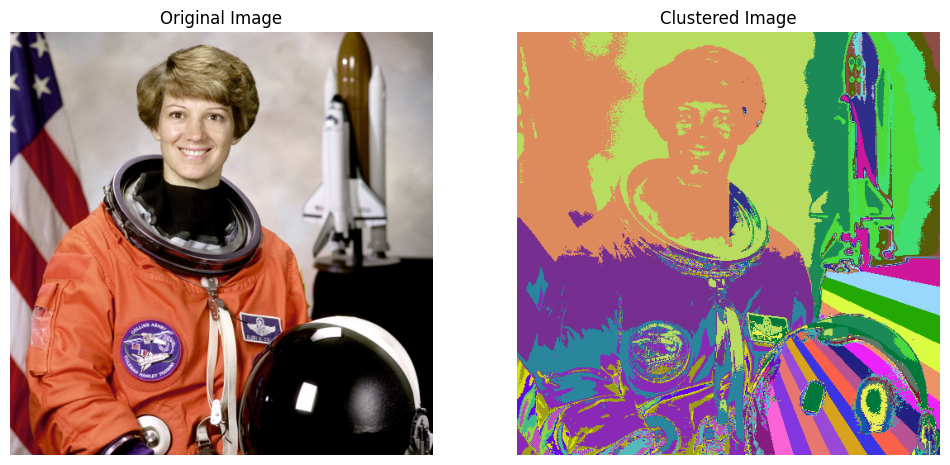

<ipython-input-61-c48fd4b1b334>:128: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


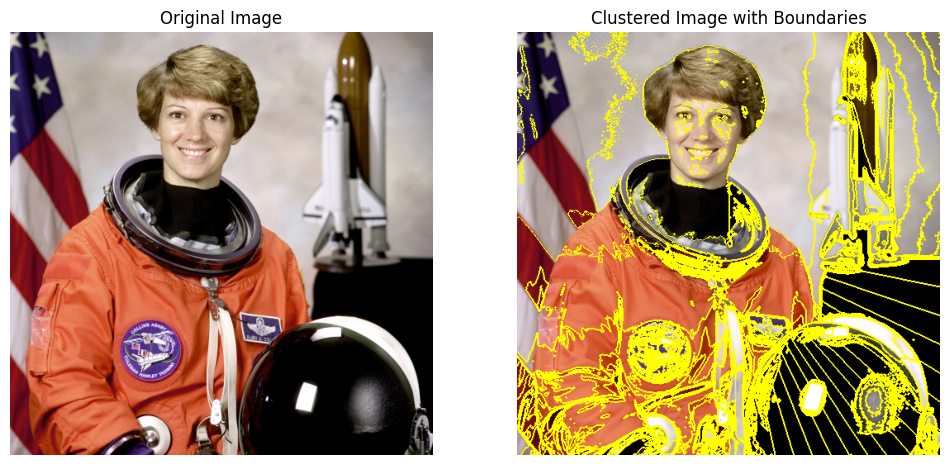

In [61]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

def context_clustering(P, c, k):
    h, w  = P.shape
    Ps = P

    side_len = int(np.ceil(np.sqrt(c)))
    y_centers = np.linspace(0, h-1, side_len)
    x_centers = np.linspace(0, w-1, side_len)

    centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)

    # Limiting the number of centers to c
    centers_xy = centers_xy[:c]

    centers_rgb = np.zeros((c, 3))

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
    _, indices = nbrs.kneighbors(centers_xy)

    for i in range(c):
        if len(indices[i]) == 0:
            continue
        centers_rgb[i] = np.mean(Ps[indices[i], :3], axis=0)

    centers = np.hstack([centers_rgb, centers_xy / [w, h]])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []

    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    print("this is the c",c)
    for i in range(c):
        indices = np.where(cluster_assignments == i)[0]
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features_list = []

    n_samples = P.shape[0]

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue

        # Feature aggregating
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        # Ensure the number of rows matches n_samples
        if P_new.shape[0] != n_samples:
            raise ValueError(f"Expected P_new to have {n_samples} rows but got {P_new.shape[0]} rows.")

        aggregated_features_list.append(P_new)

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((n_samples, diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 100
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 2

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)


cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()


this is the c 24
this is the c 24
this is the c 24
this is the c 24


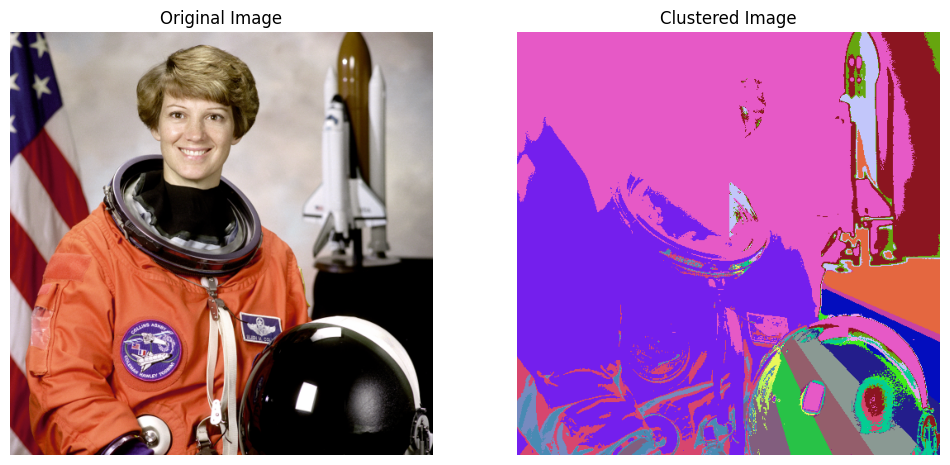

<ipython-input-76-74d5001f7523>:146: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clustered_image = np.zeros((h, w), dtype=np.int)


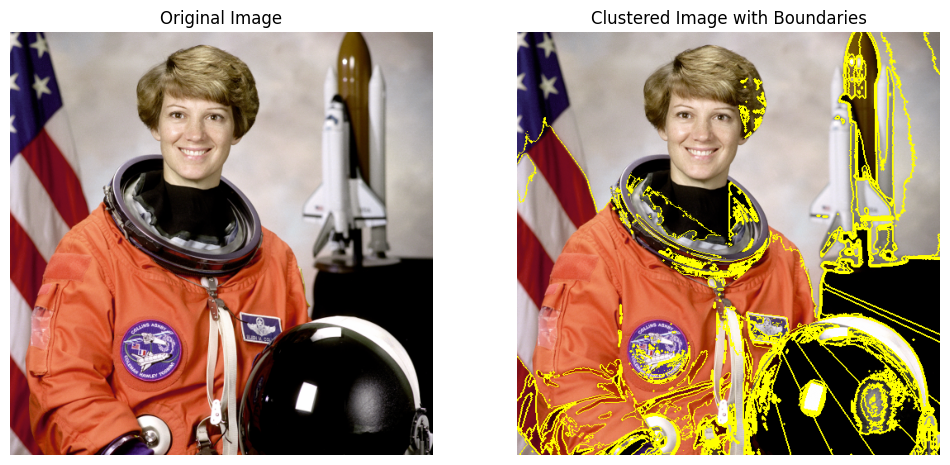

In [76]:


import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

def context_clustering(P, c, k):
    h, w  = P.shape
    Ps = P

    # Create the centers based on spatial location
    side_len = int(np.ceil(np.sqrt(c)))
    y_centers = np.linspace(0, h-1, side_len)
    x_centers = np.linspace(0, w-1, side_len)
    centers_xy = np.array(np.meshgrid(x_centers, y_centers)).T.reshape(-1, 2)
    centers_xy = centers_xy[:c]  # Limiting the number of centers to c

    # Find the RGB values corresponding to the centers using nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(Ps[:, -2:])
    distances, indices = nbrs.kneighbors(centers_xy)

    if indices is None or len(indices) == 0:
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid indices are found

    valid_centers = []
    valid_rgb_centers = []

    for i in range(c):
        if len(indices[i]) == 0 or np.any(distances[i] == 0):
            continue
        valid_rgb_centers.append(np.mean(Ps[indices[i], :3], axis=0))
        valid_centers.append(centers_xy[i])

    centers_xy = np.array(valid_centers)  # Update centers_xy to only have valid centers
    centers_rgb = np.array(valid_rgb_centers)

    if len(centers_xy) == 0:
        return np.array([]), np.array([]), np.array([])  # Return empty arrays if no valid centers are found

    centers = np.hstack([centers_rgb, centers_xy / [w, h]])
    S = cosine_similarity(Ps, centers)

    cluster_assignments = np.argmax(S, axis=1)
    return cluster_assignments, centers, S



def feature_aggregating(P, centers, S, c, alpha, beta):
    aggregated_features = []
    c = centers.shape[0]
    for i in range(c):
        s = S[:, i]
        Pv = P.copy()  # for simplicity; in practice this might involve some complex projection

        # Assuming a dummy center in value space
        vc = np.random.rand(Pv.shape[1])

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        C = 1 + np.sum(sig_values)
        g = (vc + np.sum(sig_values.reshape(-1, 1) * Pv, axis=0)) / C

        aggregated_features.append(g)

    return aggregated_features

def feature_dispatching(P, aggregated_features, cluster_assignments, c, alpha, beta):
    new_P = P.copy()
    c = len(aggregated_features)
    print("this is the c",c)
    for i in range(c):

        indices = np.where(cluster_assignments == i)[0]
        if len(indices) == 0:  # Check if indices is empty
            continue
        s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        # indices = np.where(cluster_assignments == i)[0]
        # s = np.max(cosine_similarity(P[indices], aggregated_features[i].reshape(1, -1)), axis=1)

        sig_values = 1 / (1 + np.exp(-(alpha * s + beta)))
        dispatch_value = sig_values.reshape(-1, 1) * aggregated_features[i]

        # Assuming a dummy FC layer
        FC = np.random.rand(P.shape[1], P.shape[1])
        new_P[indices] += np.dot(dispatch_value, FC)

    return new_P


def multi_head_computing(P, c, k, alpha, beta, d0, h):
    aggregated_features_list = []

    n_samples = P.shape[0]

    for _ in range(h):
        cluster_assignments, centers, S = context_clustering(P, c, k)
        if len(centers) == 0:
            continue


        # Feature aggregating
        g = feature_aggregating(P, centers, S, c, alpha, beta)

        # Feature dispatching
        P_new = feature_dispatching(P, g, cluster_assignments, c, alpha, beta)

        # Ensure the number of rows matches n_samples
        if P_new.shape[0] != n_samples:
            raise ValueError(f"Expected P_new to have {n_samples} rows but got {P_new.shape[0]} rows.")

        aggregated_features_list.append(P_new)

    # Ensure consistent array size across features
    max_dim = max([f.shape[1] for f in aggregated_features_list])
    for idx, feature in enumerate(aggregated_features_list):
        diff = max_dim - feature.shape[1]
        if diff > 0:
            padding = np.zeros((n_samples, diff))
            aggregated_features_list[idx] = np.hstack([feature, padding])

    # Concatenate the outputs of multi-head operations
    new_P = np.concatenate(aggregated_features_list, axis=1)
    return new_P




def visualize_clusters(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros_like(image)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors
    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]  # Find the index of the cluster ID in the unique list
            clustered_image[i, j] = colors[cluster_idx]
    return clustered_image



def visualize_clusters_with_boundaries(image, cluster_assignments):
    h, w, _ = image.shape
    clustered_image = np.zeros((h, w), dtype=np.int)
    unique_clusters = np.unique(cluster_assignments)
    colors = np.random.rand(len(unique_clusters), 3) * 255  # RGB colors

    for i in range(h):
        for j in range(w):
            idx = i * w + j
            cluster_id = cluster_assignments[idx]
            cluster_idx = np.where(unique_clusters == cluster_id)[0][0]
            clustered_image[i, j] = cluster_idx

    boundaries = segmentation.mark_boundaries(image, clustered_image)
    return boundaries

# Load the image
image = data.astronaut()
h, w, _ = image.shape
image_gray = rgb2gray(image)

# Prepare the data
x, y = np.meshgrid(np.arange(w), np.arange(h))
features_xy = np.column_stack((x.flatten() - w / 2, y.flatten() - h / 2)) / w
features_rgb = image.reshape(-1, 3) / 255.0
P = np.hstack([features_rgb, features_xy])

# Parameters
c = 25
k = 4
alpha = 1.0
beta = 0.0
d0 = P.shape[1]
h = 4

# Multi-head computing
new_P = multi_head_computing(P, c, k, alpha, beta, d0, h)


cluster_assignments, _, _ = context_clustering(P, c, k)

# Visualize
clustered_image = visualize_clusters(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image)
axes[1].set_title('Clustered Image')
for ax in axes:
    ax.axis('off')
plt.show()


clustered_image_with_boundaries = visualize_clusters_with_boundaries(image, cluster_assignments)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(clustered_image_with_boundaries)
axes[1].set_title('Clustered Image with Boundaries')
for ax in axes:
    ax.axis('off')
plt.show()
